In [2]:
import gym
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import theano
import theano.tensor as T
from theano.gradient import grad_clip
from theano.compile.nanguardmode import NanGuardMode
import lasagne
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, FlattenLayer, ReshapeLayer, MaxPool2DLayer, DropoutLayer
from lasagne.nonlinearities import tanh, softmax, rectify, LeakyRectify
from lasagne.objectives import squared_error
import scipy
import collections
import cPickle as pickle
import ple.games.flappybird as flappybird
from ple import PLE
import pygame


Using gpu device 0: GeForce GT 620M (CNMeM is enabled with initial size: 30.0% of memory, cuDNN not available)


coulnding import doomish
Couldn't import doom


In [3]:
class Flappy():

    def __init__(self, display=False):
        self.game = flappybird.FlappyBird(width=288, height=512, pipe_gap=100)
        self._ple = PLE(self.game, fps=30, display_screen=display)
        self.game.rng.seed(np.random.randint(0,999999))
        self.reset()

    def reset(self):
        self._ple.reset_game()
        self.game.init()
        self.game.backdrop.background_image.fill(0)
        ret = self.step(1)
        return ret[0]
        
    def render(self, close=False):
        if close:
            pygame.quit()

    def step(self, action):
        if action:
            reward = self._ple.act(119)
        else:
            reward = self._ple.act(0)

        done = self._ple.game_over();
        state =  self.game.getScreenRGB()
        info = None
        return state, reward, done, info

class ReplayMemory:
    def __init__(self, input_size, items = 10):
        # caches
        self._state  = np.zeros((items,) + input_size, dtype = np.float32)
        self._action = np.zeros((items,1), dtype = np.int32)
        self._reward = np.zeros((items,1), dtype = np.float32)
        self._done   = np.zeros((items,1), dtype = np.bool)
        self._nextState = np.zeros((items,) + input_size, dtype = np.float32)
        
        self.pointer = 0
        self.items = items
        self.isFull = False;
        self.input_size = input_size
        
    def append(self, state, action, reward, done, nextState):
        self._state[self.pointer] = state
        self._action[self.pointer] = action
        self._reward[self.pointer] = reward
        self._done[self.pointer] = done
        self._nextState[self.pointer] = nextState
        
        self.pointer += 1
        if self.pointer >= self.items:
            self.isFull = True
            self.pointer = 0
            
    def itemsToSample(self):
        return self.items if self.isFull else self.pointer
    
    def get_batch(self, size):
        indices =  np.random.choice(self.itemsToSample(), size=size,replace=False)
        
        state = self._state[indices]
        action = self._action[indices]
        reward = self._reward[indices]
        done = self._done[indices]
        nextState = self._nextState[indices]
        return state, action, reward, done, nextState
    
    def clear(self):
        self._state[:]  = 0
        self._action[:] = 0
        self._reward[:] = 0
        self._done[:]   = 0
        self._nextState[:] = 0
        self.pointer = 0
        self.isFull = False

# Pickle helper functions
def pickleSave(object_,filename):
    with open(filename, 'wb') as f:
            pickle.dump(object_, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickleLoad(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def simple_network4(input_size, output_size):
    l_in = InputLayer(shape=((None, ) + input_size), name='inputLayer')
    
    #print lasagne.layers.get_output_shape(l_in)

    network = lasagne.layers.Conv2DLayer(
        l_in, num_filters=32, filter_size=(8, 8), stride=4, pad=2,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = MaxPool2DLayer(network, 2)
    
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=64, filter_size=(4, 4), stride=2, pad=1,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = MaxPool2DLayer(network, 2, pad=1)
    
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=64, filter_size=(3, 3), stride=1, pad=1,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = MaxPool2DLayer(network, 2, pad=1)

    network = lasagne.layers.DenseLayer(
        network,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = lasagne.layers.DenseLayer(
        network,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))

    network = lasagne.layers.DenseLayer(
        network,
        num_units = output_size,
        nonlinearity=None,
        b=lasagne.init.Constant(.1))
    
    return network

class DeepQNetwork:
    def __init__(self, input_size, output_size, build_network = simple_network4,
                 discount = 0.99,
                 learningRate = 0.0001,
                 frozen_network_update_time = 1000):
        
        print "Initializing new Q network"
        
        self.input_size = input_size
        self.output_size = output_size
        self.discount = discount
        self.learningRate = learningRate
        
        self.frozen_network_update_time = frozen_network_update_time;
        self.frozen_timer = 0;
        self.epoch = 0
        
        # logging variables
        self.log = {"batchMeanQValue":[],"batchMeanTargetQValue":[], "cost":[],'performance':[], 'epoch':[]}
        
        # symbolic inputs
        sym_state = T.tensor4('state') #Batchsize, channels, X, Y
        sym_action = T.icol('action')
        sym_reward = T.col('reward')
        sym_isDone = T.bcol('isDone')
        sym_nextState = T.tensor4('nextState')
        
        # networks
        self.network = build_network(input_size, output_size)
        self.frozen_network = build_network(input_size, output_size)
        self.update_frozen_network()
        
        # forward pass
        print "Compiling forward passes"
        self.forward_pass = theano.function([sym_state],
                                            lasagne.layers.get_output(self.network,
                                                                      sym_state,
                                                                      deterministic=True))
        
        self.frozen_forward_pass = theano.function([sym_state],
                                            lasagne.layers.get_output(self.frozen_network,
                                                                      sym_state,
                                                                      deterministic=True))
        
        clipped_reward = T.clip(sym_reward,-1,1)
        #cost function definition
        cost, error, q_action, q_target = self.build_cost_function(sym_state,
                                                              sym_action,
                                                              clipped_reward,
                                                              sym_isDone,
                                                              sym_nextState)
               
        params = lasagne.layers.get_all_params(self.network, trainable=True)
        update_function = lasagne.updates.adam(cost, params, learning_rate=self.learningRate)
        
        # training function
        print "Compiling training function"
        self._train = theano.function([sym_state, sym_action, sym_reward, sym_isDone, sym_nextState],
                                        [cost, error, q_action, q_target],
                                        updates=update_function)
        
    def build_cost_function(self, state, action, reward, isDone, nextState):
        # forward pass state, action pairs to find network output
        q_values = lasagne.layers.get_output(self.network, state, deterministic=False)
        actionmask = T.eq(T.arange(self.output_size).reshape((1, -1)), action)
        q_action = T.sum(actionmask * q_values, axis = 1, keepdims=True)
        
        # forward pass next state,max action + true reward to find target on frozen network
        #should this be nondeterministic as well?
        q_next = T.max(lasagne.layers.get_output(self.frozen_network, nextState), axis = 1, keepdims=True);
        q_target = reward + self.discount*((1-isDone) * q_next)
        
        # determine cost as mean squared error
        error = q_target - q_action
        cost = T.mean( 0.5 * error ** 2 + np.abs(error))
        
        
        loss = cost# + 1e-12*lasagne.regularization.regularize_network_params(self.network, lasagne.regularization.l2)
        
        return loss, error, q_action, q_target
        
    def update_frozen_network(self):
        print "Update frozen network"
        lasagne.layers.set_all_param_values(self.frozen_network, lasagne.layers.get_all_param_values(self.network))
        
    def getNetworkParameters(self):
        return lasagne.layers.get_all_param_values(self.network)
    
    def setNetworkParameters(self, parameter_values):
        lasagne.layers.set_all_param_values(self.network, parameter_values)
        
    def saveNetwork(self, filename):
        obj = {}
        obj['log'] = self.log
        obj['frozen_timer'] = self.frozen_timer
        obj['epoch'] = self.epoch
        obj['networkParameters'] = self.getNetworkParameters()
        with open(filename, 'wb') as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def loadNetwork(self, filename):
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
            self.log = obj['log']
            self.frozen_timer = obj['frozen_timer']
            self.epoch = obj['epoch']
            self.setNetworkParameters(obj['networkParameters'])
            self.update_frozen_network()
    
    def train(self, state, action, reward, isDone, nextState):
        self.epoch += 1
        # Update frozen network check
        self.frozen_timer += 1
        if self.frozen_timer > self.frozen_network_update_time:
            self.update_frozen_network()
            self.frozen_timer = 0
        
        # Train
        cost, error, q_action, q_target = self._train(state, action, reward, isDone, nextState)
        
        # Log
        if self.epoch % 10 == 0:
            self.log['epoch'].append(self.epoch)
            self.log['batchMeanQValue'].append(np.mean(q_action, axis = 0)[0])
            self.log['batchMeanTargetQValue'].append(np.mean(q_target, axis = 0)[0])
            self.log['cost'].append(cost)
        
        return cost, error, q_action, q_target

    def eval(self, state):
        return self.forward_pass(state[None,:])
    
    def evalAll(self, state):
        return self.forward_pass(state)
    
    def evalFrozen(self, state):
        return self.frozen_forward_pass(state[None,:])

class Agent:
    def __init__(self, envname,
                 Qfunction = None,
                 batch_size = 32,
                 cropout = (32,-16,8,-8),
                 input_size = (1,128,128),
                 action_space_size = 4,
                 replay_memory_size = 1024,
                 build_network = simple_network4,
                 discount = 0.99,
                 display = False,
                 learningRate=0.0001):
        
        self.cropout = cropout
        self.input_size = input_size
        self.screen_size = input_size[1:]
        self.batch_size = batch_size
        self.action_space_size = action_space_size
        self.environment = Flappy(display=display) #gym.make(envname)
        self.stateVector = collections.deque(maxlen=self.input_size[0])
        
        if Qfunction == None:
            self.Qfunction = DeepQNetwork(input_size  = input_size,
                                          output_size = action_space_size,
                                          build_network = build_network,
                                          learningRate = learningRate,
                                          discount = discount)
        else:
            self.Qfunction = Qfunction
        
        self.replay = ReplayMemory(input_size, replay_memory_size)
        
        self.reset()
        
    def reset(self):
        state = self.preprocessState(self.environment.reset())
        # clean history
        self.stateVector.clear();
        for i in range(self.stateVector.maxlen):
            self.stateVector.append(state)
            
        return state
    
    def saveNetwork(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.Qfunction, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    def preprocessState(self, state):
        # Crop
        stateProcessed = state[self.cropout[0]:self.cropout[1],self.cropout[2]:self.cropout[3],:]
        # RGB -> BW
        stateProcessed = (stateProcessed*np.array([0.001167578125, 0.00229296875, 0.0004453125])).sum(axis=2)
        # Resize
        stateProcessed = scipy.misc.imresize(stateProcessed, self.screen_size, interp='nearest')
        return stateProcessed.astype(np.float32)
    
    def step(self, action):
        (state, reward, done, info) = self.environment.step(action)
        self.stateVector.append(self.preprocessState(state))
        return (self.stateVector, reward, done, info, state)
    
    def getAction(self, epsilon = None, set_ = None):   
        # Be greedy or random
        if np.random.uniform(0,1) >= epsilon:
            action = self.Qfunction.eval(np.array(self.stateVector)).argmax()
        else:
            if set_ and np.random.uniform(0,1) > 0.05:
                action = np.random.choice(set_)
            else:
                action = np.random.randint(self.action_space_size)
        
        return action
    
    def testPerformance(self, episodes, Tmax = 10000, epsilon = 0.05, render = False, frameskip = 1):
        averageEpisodeReward = 0
        averageEpisodeTime = 0
        actions = []
        
        for episode in range(episodes):
            self.reset()

            for t in range(Tmax):
                if render:
                    self.environment.render()
                
                action = self.getAction(epsilon = 0.05)
                actions.append(action)
                
                for i in range(frameskip):
                    (currentState, reward, done, info, state) = self.step(action)
                    averageEpisodeReward += reward

                if done:
                    break
        
            averageEpisodeTime +=t
        
        if render:
            self.environment.render(close=True)
        
        actionDistribution = collections.Counter(actions)
        averageEpisodeReward /= episodes
        averageEpisodeTime /= episodes
        
        self.Qfunction.log['performance'].append({'epoch':self.Qfunction.epoch,
                                             'episodes':episodes,
                                             'Tmax':Tmax,
                                             'epsilon':epsilon,
                                             'averageEpisodeTime':averageEpisodeTime,
                                             'averageEpisodeReward':averageEpisodeReward,
                                             'actionDistribution':actionDistribution})
        
        return averageEpisodeTime, averageEpisodeReward, actionDistribution        
        
    def recordReplay(self, episodes, Tmax = 1000000, epsilon = 0.3, frameskip = 1, replayskip = 1, actionset = None):
        if episodes > 1:
            print "Recording %u episodes with epsilon %1.3f" % (episodes, epsilon) 
        # metrics
        averageEpisodeReward = 0
        averageEpisodeTime = 0
        for episode in range(episodes):
            self.reset()
            for t in range(Tmax):
                # extract current state
                state = np.array(self.stateVector)
                
                # choose action via epsilon greedy method
                action = self.getAction(epsilon, actionset)
                
                # perform action for [frameskip] steps
                totalReward = 0
                
                for i in range(frameskip):
                    (nextState, reward, done, _, s) = agent.step(action)
                    totalReward += reward
                    
                    if done:
                        #totalReward -= 1
                        break
                
                totalReward = np.clip(totalReward, -1, 1)
                
                averageEpisodeReward += totalReward
                
                #extract nextState
                nextState = np.array(self.stateVector)
                
                if totalReward != 0 or done or (t + episode) % replayskip == 0:
                    # add step to replay memory
                    self.replay.append(state, action, totalReward, done, nextState)
                    
                # continue to next episode/game
                if done:                    
                    break;
            
            #self.assignTrueDiscountedFutureReward(self.replay.pointer-1, Tmax, self.Qfunction.discount)
            
            averageEpisodeTime += t
        
            if episode % 50 == 49:
                    print "Recording: episode %d\t avg time %s\t avg reward %s" % (episode + 1,
                                averageEpisodeTime/(episode+1), averageEpisodeReward/(episode+1) )

        averageEpisodeReward /= episodes
        averageEpisodeTime /= episodes
        
        return averageEpisodeTime, averageEpisodeReward
    
    def assignTrueDiscountedFutureReward(self, endTime, Tmax, discount):
        i = endTime
        if i == -1:
            i = self.replay.items
            
        rtrace = 0.0
        for x in range(Tmax):
            rtrace += self.replay._reward[i]
            self.replay._reward[i] = rtrace
            self.replay._done[i] = True

            i -= 1
            rtrace *= discount
            if i == -1 and self.replay.isFull:
                i = self.replay.items - 1
            if self.replay._done[i]:
                break
    
    def loadRecordedDataToReplay(self, filename):
        print "Loading replay data from %s" % filename
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            
            # clean history
            self.stateVector.clear();
            for i in range(self.stateVector.maxlen):
                self.stateVector.append(self.preprocessState(data[0][0]))
                
            for t in data:
                # unpack (state,action,reward,done)
                state = t[0]
                action = t[1]
                reward = t[2]
                done = t[3]
                
                # extract current state
                stateA = np.array(self.stateVector)
                
                self.stateVector.append(self.preprocessState(state))
                
                #extract nextState
                nextStateA = np.array(self.stateVector)
                
                # add step to replay memory
                self.replay.append(stateA, action, reward, done, nextStateA)
                
                # continue to next episode/game 
                if done == 2:
                    # clean history
                    self.stateVector.clear();
                    for i in range(self.stateVector.maxlen):
                        self.stateVector.append(self.preprocessState(data[0][0]))       
                    
    def trainFromReplay(self, batch_size):
        # check replay memory size
        if self.replay.itemsToSample() > self.batch_size:

            # sample random minibatch of transitions from D
            state, action, reward, done, nextState = self.replay.get_batch(batch_size)

            # train
            cost = self.Qfunction.train(state, action, reward, done, nextState)

            # log
            if self.Qfunction.epoch % 500 == 0:
                print self.Qfunction.epoch, cost[0]


def epsilon_scheme_linear(t, tstart, estart, tend, eend):
    if t <= tstart:
        return estart
    elif t >= tend:
        return eend
    r = (t-tstart)/float(tend-tstart)
    return (1-r)*estart + r*eend

In [3]:
agent = Agent("Flappy",
    replay_memory_size = 2**15,
    input_size = (3,80,80),
    build_network = simple_network4,
    cropout = (0,-1,0,-90),
    action_space_size=2,
    display = True,
    discount=.90,
    learningRate=0.00001)

Initializing new Q network
Update frozen network
Compiling forward passes
Compiling training function


In [ ]:
t, reward = agent.recordReplay(episodes=50, Tmax = 800,
                    epsilon=epsilon_scheme_linear(agent.Qfunction.epoch, 50000, 1, 500000, 0.1),
                    frameskip = 2, replayskip = 1)

In [ ]:
agent.Qfunction.frozen_network_update_time = 10000
for game in range(5000):
    #print "training epoch %u" % a
    t, reward = agent.recordReplay(episodes=1, Tmax = 800,
                                   epsilon=epsilon_scheme_linear(agent.Qfunction.epoch, 50000, 1, 500000, 0.1),
                                   frameskip = 1, replayskip = 8)
    for i in range(min(t,500)):
        agent.trainFromReplay(32)
    
    if game % 25 == 0:
        agent.testPerformance(10)
        print "Performance: %s " % agent.Qfunction.log['performance'][-1]


Initializing new Q network
Update frozen network
Compiling forward passes
Compiling training function
Update frozen network


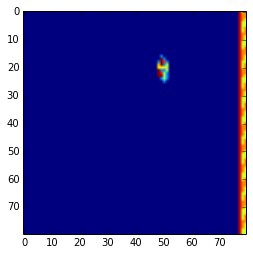

In [3]:
#agent.trainFromReplay(32)
agent = Agent("Flappy",
    replay_memory_size = 2**18,
    input_size = (3,80,80),
    build_network = simple_network4,
    cropout = (0,-1,0,-90),
    action_space_size=2,
    display = True,
    discount=.90)
agent.Qfunction.loadNetwork("experiments/flappy2/QNetwork35.bin")
plt.imshow(agent.stateVector[-1])

In [ ]:
print agent.replay._reward
plt.plot(agent.replay._reward[0:agent.replay.itemsToSample()], 'x')

Total Reward: -100.0


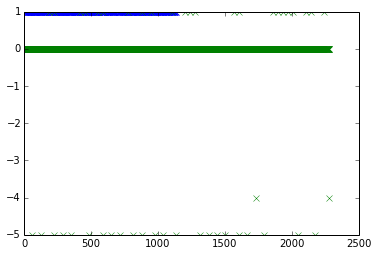

In [6]:
a = []
Qvals = []
totalReward = 0
rewards = []
gameState = [];
for game in range(25):
    agent.environment.reset()
    for _ in range(800):
        agent.environment.render()
        action = agent.getAction(epsilon = 0.000)
        gameState.append(agent.environment.game.getGameState())
        a.append(action)
        for i in range(2):
            (currentState, reward, done, info, state) = agent.step(action)
            Qvals.append(agent.Qfunction.eval(np.array(agent.stateVector)))
            totalReward += reward
            rewards.append(reward)
        if done:
            break
    #print action
#agent.environment.render(close=True)
print "Total Reward: %s" % totalReward
plt.plot(a,'x')
plt.plot(rewards,'x')

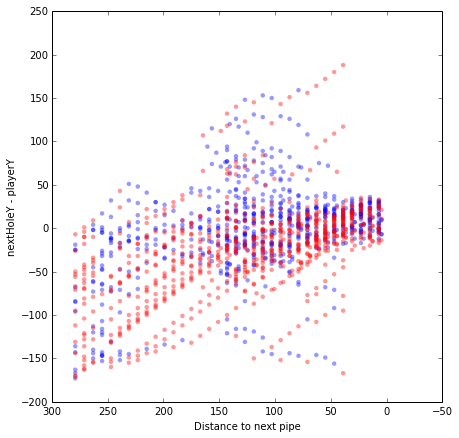

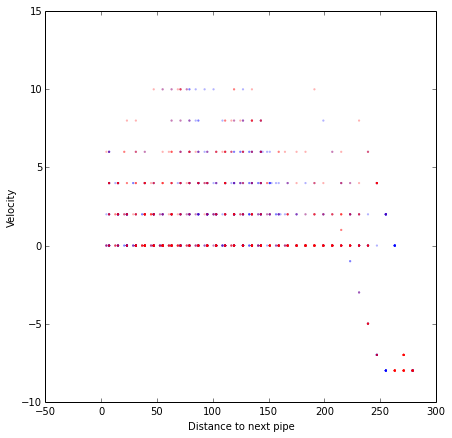

In [60]:
plt.figure(figsize=(7, 7),frameon=False)
action0 = np.array(filter(lambda (s,a) : a==0 , zip(gameState, a)))[:,0]
action1 = np.array(filter(lambda (s,a) : a==1 , zip(gameState, a)))[:,0]
#print [x['player_vel'] for x in action0]
plt.scatter([x['next_pipe_dist_to_player'] for x in action0],
            [(x['next_pipe_bottom_y']+x['next_pipe_top_y'])/2.0-x['player_y'] for x in action0], marker='o', linewidths=0, alpha=0.4)
plt.scatter([x['next_pipe_dist_to_player'] for x in action1],
            [(x['next_pipe_bottom_y']+x['next_pipe_top_y'])/2.0-x['player_y'] for x in action1], c='r',  marker='o', linewidths=0, alpha=0.4)
plt.xlabel('Distance to next pipe')
plt.ylabel('nextHoleY - playerY')
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])


plt.figure(figsize=(7, 7))
plt.scatter([x['next_pipe_dist_to_player'] for x in action0],
            [x['player_vel'] for x in action0], marker='.', linewidths=0, alpha=0.3)
plt.scatter([x['next_pipe_dist_to_player'] for x in action1],
            [x['player_vel'] for x in action1], c='r',  marker='.', linewidths=0, alpha=0.3)
plt.xlabel('Distance to next pipe')
plt.ylabel('Velocity')

Layer 1 filter values


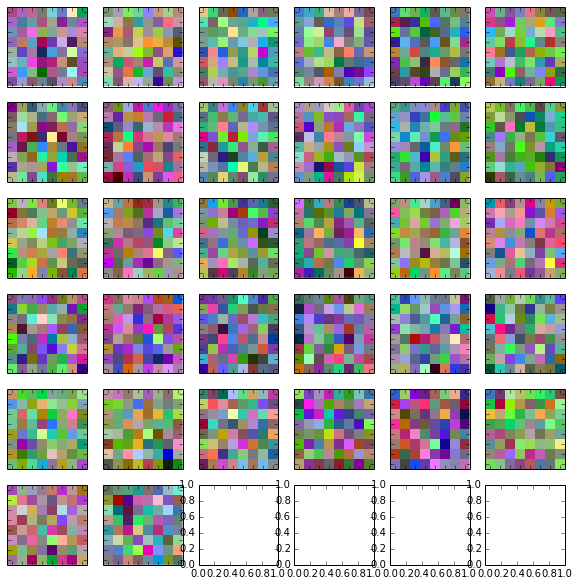

In [61]:
parameterValues = [p.get_value() for p in lasagne.layers.get_all_params(agent.Qfunction.network, trainable=True) if p.name=='W']

def conv4d(f,k, stride=1):
    out = np.zeros((k.shape[0], f.shape[1], f.shape[2] + k.shape[2] -1, f.shape[3] + k.shape[3] -1))
    for i in range(k.shape[0]):
        if not k.shape[1] == f.shape[0]:
            print "ERROR wrong size"
        for j in range(f.shape[0]):
            for l in range(f.shape[1]):
                out[i,l,:,:] += scipy.signal.convolve2d(f[j,l,:,:],k[i,j,:,:])
    return out

filters = parameterValues[0]# conv4d(parameterValues[0],parameterValues[1])
#filters = conv4d(filters,parameterValues[2])

num_filters = filters.shape[0]
n = int(np.ceil(num_filters**0.5))
fig, ax = plt.subplots(n,n, figsize=(10,10))
print "Layer 1 filter values"
j = 0
for i in range(n):
    for j in range(n):
        if i*n+j < filters.shape[0]:
            f = np.transpose(filters[i*n+j,:,:,:], (1,2,0))
            f = (f - f.min(axis=(0,1))[np.newaxis, np.newaxis,:]) / ((f.max(axis=(0,1)) - f.min(axis=(0,1)))[np.newaxis, np.newaxis,:])
            ax[i,j].imshow(f, cmap='gray', interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())
            


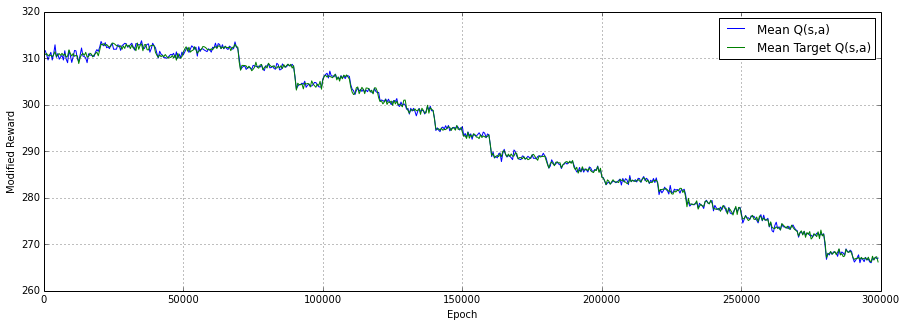

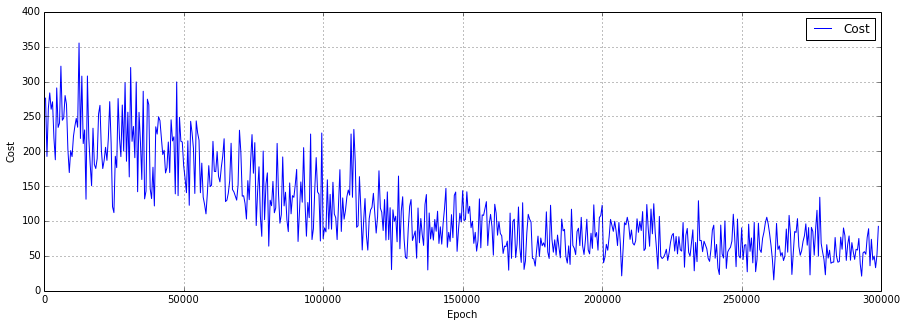

In [4]:
log = pickleLoad("experiments/flappylearnsbreakout/QNetworkPre.bin")['log']
#log = pickleLoad("experiments/flappy2/QNetwork35.bin")['log']
kernel_size = 50
filter_kernel = np.ones(kernel_size)/kernel_size

batchMeanQTarget = np.convolve(
    np.array(log['batchMeanTargetQValue']),
    filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size]
batchMeanQ = np.convolve(
    np.array(log['batchMeanQValue']),
    filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size]
cost = np.convolve(
    np.array(log['cost']),
    filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size]
epochLog = np.array(log['epoch'])[kernel_size:-kernel_size:kernel_size]

plt.figure(figsize=(15, 5))
plt.plot(epochLog, batchMeanQ)
plt.plot(epochLog, batchMeanQTarget)
plt.grid(True)
plt.legend(['Mean Q(s,a)', 'Mean Target Q(s,a)'],'upper right')
plt.xlabel('Epoch')
plt.ylabel('Modified Reward')
#plt.ylim([-10,10])

plt.figure(figsize=(15, 5))
plt.plot(epochLog, cost)
plt.grid(True)
plt.legend(['Cost'],'upper right')
plt.ylabel('Cost')
plt.xlabel('Epoch')
#plt.ylim([0,1])



In [91]:
avgTime, avgReward = agent.recordReplay(episodes = 30, epsilon = 0.00001, Tmax = 1600,
        frameskip = 2)

Recording 30 episodes with epsilon 0.000


In [90]:
Qval = agent.Qfunction.evalAll(agent.replay._state[0:400])#agent.replay.itemsToSample()])

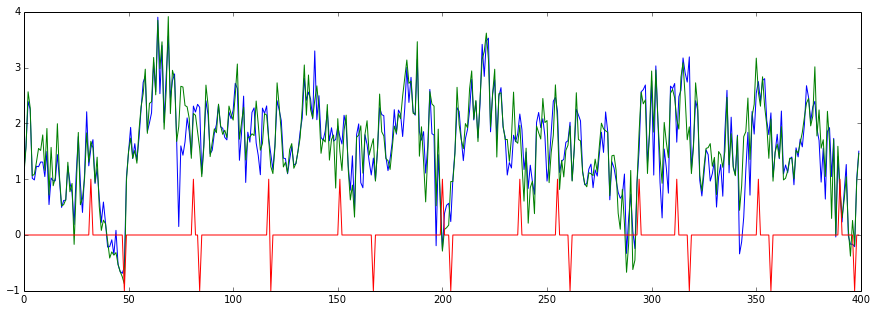

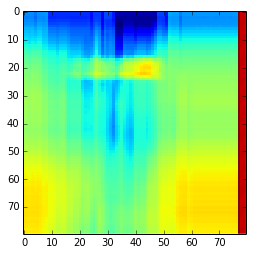

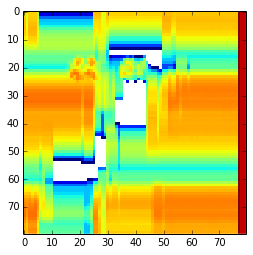

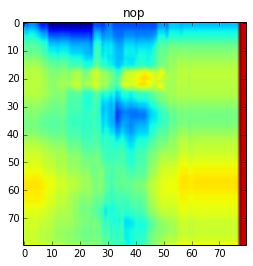

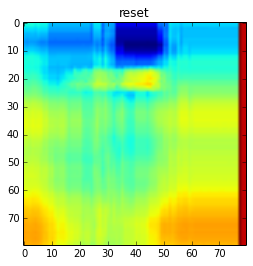

In [65]:
mask = Qval.max(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(Qval)
plt.plot(agent.replay._reward[0:len(mask)])
states = agent.replay._state[0:len(mask)]
plt.figure()
plt.imshow(np.log(states[mask>1.2].mean(axis = (0,1))), interpolation='none')
plt.figure()
plt.imshow(np.log(states[mask<0].mean(axis = (0,1))), interpolation='none')

heatmaps = []
for i in range(4):
    heatmaps.append(states[Qval.argmax(axis = 1)==i].sum(axis = (0,1)))
                    
heatmaps = np.log(np.array(heatmaps))
#heatmaps = (heatmaps / heatmaps.sum(axis=0)[np.newaxis, :])
#heatmaps[np.isnan(heatmaps)] = 0

actionlabels = ['nop', 'reset']
for i,label in enumerate(actionlabels):
    plt.figure()
    plt.title(label)
    plt.imshow(heatmaps[i,:,:])
    plt.savefig("ActionHeatmap%s.png" % label)